# Run Comparer

In [1]:
from content_opener import open_all_contents, open_contents, Results, Settings, Values, Labels
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

datasets:
'CIFAR10',
'CIFAR100'

nets:
'ResNet18'

optimizers:
'SGD',
'Adam',
'AdaSecant'

cycles:
'constantLR',
'100-cycle',
'50-cycle',
'25-cycle'

decays:
'exponentialDecay=False',
'exponentialDecay=True',
'exponentialDecay=maxLR',
'exponentialDecay=slope'


learning rates:
'lr=0.001',
'lr=0.01',
'lr=0.1',
'lr=1',
'lr=3',
'lr=0.01-1',
'lr=0.01-3',
'lr=0.001-1',
'lr=0.001-3',
'lr_max=1',
'lr_max=3',
'lr_max=10'

batch-sizes:
'batch-size=32',
'batch-size=128',
'batch-size=512',
'batch-size=2048'

In [24]:
def compare_runs(settings_list: List[Settings], stop=None, stop_1cycle=False, ylim=None, 
                 compare_what='accuracy', y_scale='linear', label_type=None):
    results = open_all_contents(settings_list)
    fig = plt.figure()
    if stop == None:
        stop = len(results[0].values.val_accuracy)
    if stop_1cycle:
        for i in range(len(results)):
            results[i].to_one_cycle()
    for i in range(len(results)):
        if label_type is None:
            label = (results[i].get_labels().optimizer + ' ' + results[i].get_labels().cycle 
                     + results[i].get_labels().initial_lr + results[i].get_labels().max_lr)
        if label_type == 'batch_size':
            label = 'batch size ' + results[i].get_labels().batch_size
        if compare_what == 'accuracy':
            if len(results) == 2 and i == 1:
                plt.plot(results[i].values.val_accuracy[:stop], 
                         label=label, color='g')
            else:
                plt.plot(results[i].values.val_accuracy[:stop], 
                         label=label)
        elif compare_what == 'val_loss':
            plt.plot(results[i].values.val_loss[:stop], 
                     label=label)
        elif compare_what == 'train_loss':
            plt.plot(results[i].values.train_loss[:stop], 
                     label=label)
        else:
            raise RuntimeError('compare_what must be either "accuracy", "val_loss", or "train_loss"')
    plt.xlabel('Epochs')
    if compare_what == 'accuracy':
        plt.ylabel('Validation Accuracy')
    elif compare_what == 'val_loss':
        plt.ylabel('Validation Loss')
    elif compare_what == 'train_loss':
        plt.ylabel('Training Loss')
    plt.yscale(y_scale)
    plt.ylim(ylim)
    plt.legend()
    plt.grid()
    fig.savefig(f'Plots/name_me.svg')
    
def plot_cycles(settings_list: List[Settings], 
                stop=None, stop_1cycle=False, ylim=None, in_epochs=False, has_label=True, y_scale='linear'):
    results = open_all_contents(settings_list)
    fig = plt.figure()
    if stop == None:
        stop = len(results[0].values.lr_history)
    if stop_1cycle:
        for i in range(len(results)):
            results[i].to_one_cycle()
    for i in range(len(results)):
        if has_label:
            label = results[i].get_labels().cycle
        else:
            label = None
        plt.plot(results[i].values.lr_history[:stop], label=label)
    if in_epochs:
        iterations = len(results[0].values.lr_history)
        batch_size = float(results[0].get_labels().batch_size)
        step = 20 * 50000 // batch_size
        plt.xticks(np.arange(0, iterations + step, step=step), np.arange(0, 101, 20))
        plt.xlabel('Epochs')
    else:
        plt.xlabel('Iterations')
    plt.ylabel('Learning Rate')
    plt.ylim(ylim)
    plt.legend()
    plt.grid()
    plt.yscale(y_scale)
    fig.savefig(f'Plots/name_me.svg')

## Settings

In [56]:
settings_list = []

dataset = 'CIFAR10'
net = 'ResNet18'
optimizer = 'SGD'
decay = 'exponentialDecay=False'
lr = 'lr=0.01'
lr_adam = 'lr=0.001'
clr = 'lr=0.001-1'
secant_lr1 = 'lr_max=3'
secant_lr2 = 'lr_max=10'
batch_size = 'batch_size=128'
cycle = 'constantLR'

#settings_list.append(Settings(dataset, net, optimizer, cycle, decay, lr_adam, 'batch_size=32'))
#settings_list.append(Settings(dataset, net, optimizer, cycle, decay, lr_adam, batch_size))
#settings_list.append(Settings(dataset, net, optimizer, cycle, decay, lr_adam, 'batch_size=512'))

#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=0.001', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=0.01', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=0.1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=3', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'constantLR', decay, 'lr=0.1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'randomLR', decay, 'lr=0.001-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'decayingLR', decay, 'lr=0.001-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, 'decayingLR', decay, 'lr=0.001-3', batch_size))
#settings_list.append(Settings(dataset, 'ResNet50', optimizer, 'constantLR', decay, lr, batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '100-cycle', decay, 'lr=0.01-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '100-cycle', decay, 'lr=0.01-3', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '100-cycle', decay, 'lr=0.001-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '100-cycle', decay, 'lr=0.001-3', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '25-cycle', decay, 'lr=0.01-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '25-cycle', decay, 'lr=0.01-3', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '25-cycle', decay, 'lr=0.001-1', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '25-cycle', decay, 'lr=0.001-3', batch_size))
#settings_list.append(Settings(dataset, net, optimizer, '10-cycle', decay, clr, batch_size))
#settings_list.append(Settings(dataset, net, 'SimpleAdaSecant', 'calculatedLR', decay, 'lr_max=3', batch_size))
#settings_list.append(Settings(dataset, net, 'SimpleAdaSecant', 'calculatedLR', decay, 'lr_max=10', batch_size))
settings_list.append(Settings(dataset, net, 'AdaSecant', 'calculatedLR', decay, 'lr=None', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', 'constantLR', decay, 'lr=0.0001', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', 'constantLR', decay, lr_adam, batch_size))
#settings_list.append(Settings(dataset, net, 'CUS-Adam', 'constantLR', decay, lr_adam, batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '25-cycle', decay, 'lr=0.0001-0.03', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', 'constantLR', decay, 'lr=0.01', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', 'constantLR', decay, 'lr=0.1', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '100-cycle', decay, 'lr=0.001-0.3', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '100-cycle', decay, 'lr=0.0001-0.3', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '100-cycle', decay, 'lr=0.0001-0.01', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '100-cycle', decay, 'lr=0.0001-0.03', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '10-cycle', decay, 'lr=0.0001-0.03', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', '100-cycle', decay, 'lr=0.0001-0.01', batch_size))
#settings_list.append(Settings(dataset, net, 'Adam', 'constantLR', decay, 'lr=1', batch_size))

## Compare Accuracies

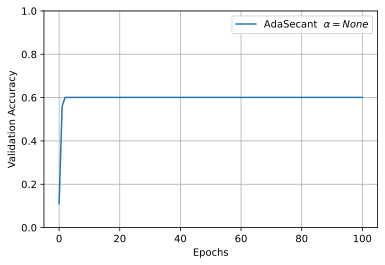

In [57]:
y_lim = (0, 1)
#y_lim = (0.7, 0.9)
#y_lim = (0.4, 0.6)

compare_runs(settings_list, stop_1cycle=False, ylim=y_lim)

Over all experiments, we observe 25-cycle to be the best setting regarding both convergence speed and maximum accuracy. Even though the 10-cycle setting converges slightly faster at the beginning, it does not yield final results comparable to those of the 25-cycle setting.

Even though the results in the original paper are more impressive, this reproduction shows that the super-convergence phenomenon is quite easy to observe. More importantly, the results seem to be more dependent on the cycle length than the learining rate range, suggesting a greater importance. Furthermore, it suggests that the results are very robust.

## Show LR-History

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (6).

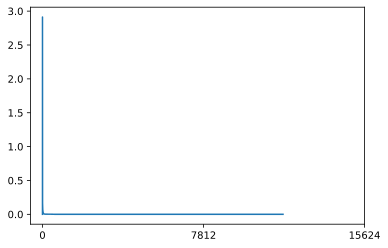

In [58]:
plot_cycles(settings_list, stop_1cycle=False, in_epochs=True)

In [ ]:
plot_cycles([Settings(dataset, net, optimizer, '25-cycle', decay, clr, batch_size)], 
            stop_1cycle=False,
            in_epochs=True,
            has_label=False)

## Compare Loss

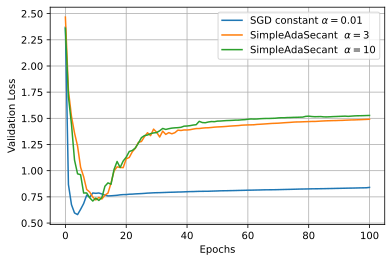

In [44]:
compare_runs(settings_list, compare_what='val_loss')

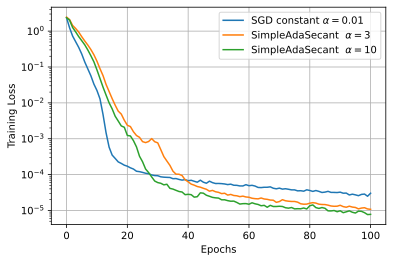

In [46]:
compare_runs(settings_list, compare_what='train_loss', y_scale='log')

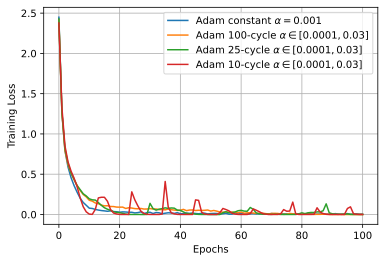

In [9]:
compare_runs(settings_list, compare_what='train_loss')

The CLR scheme works intuitively by downscaling larger gradients on the steep peaks and by upscaling smaller gradients on long plateus. Therefore, one would predict the training loss to decrease notably more quickly when using CLR. The observations do not show a clear pattern here. This expectation could not be validated. (really? - kind of)

Since super-convergence could be observed for the validation accuracy but not for the training loss, this intuitive explanation does not seem to be the main driver for this phenomenon. A better explanation seems to be that the optima are less sharp when using CLR, optimizing the nets performance on new data.